# <center>Road Accident Collisions Analysis</center>

<img src="Arrive_Alive-logo-1425D96C33-seeklogo.com.png"> 

### Load Libraries

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
from pandasql import sqldf
import pandasql as ps
import seaborn as sns
import requests
import math
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
cd /home/simphiwe/Documents/notebooks/Car_Accidents

/home/simphiwe/Documents/notebooks/Car_Accidents


### Load data 

In [3]:
def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename

In [4]:
dat = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD", 
                    'NYPD Motor Vehicle Collisions.csv')

In [7]:
df = pd.read_csv('NYPD Motor Vehicle Collisions.csv', low_memory=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454596 entries, 0 to 1454595
Data columns (total 29 columns):
DATE                             1454596 non-null object
TIME                             1454596 non-null object
BOROUGH                          1021039 non-null object
ZIP CODE                         1020865 non-null object
LATITUDE                         1270753 non-null float64
LONGITUDE                        1270753 non-null float64
LOCATION                         1270753 non-null object
ON STREET NAME                   1176688 non-null object
CROSS STREET NAME                994547 non-null object
OFF STREET NAME                  185767 non-null object
NUMBER OF PERSONS INJURED        1454579 non-null float64
NUMBER OF PERSONS KILLED         1454566 non-null float64
NUMBER OF PEDESTRIANS INJURED    1454596 non-null int64
NUMBER OF PEDESTRIANS KILLED     1454596 non-null int64
NUMBER OF CYCLIST INJURED        1454596 non-null int64
NUMBER OF CYCLIST KILLED         

# Data Cleaning and Feature engineering

##### Overview of collision causes

##### Clean up the time variables and extract date, month, year and day of the week

In [9]:
df['Date_1'] = df['DATE'] + ' ' + df['TIME']
df['timestamp'] = pd.to_datetime(df['Date_1'], format='%m/%d/%Y %H:%M')

In [10]:
df['day_of_week'] = df['timestamp'].dt.weekday_name #Name of the week
df['hours'] = df['timestamp'].dt.hour  #Hour
df['year'] = df['timestamp'].dt.year #year
df['month'] = df['timestamp'].dt.month_name() #day
df['date'] = pd.to_datetime(df['timestamp'].dt.date) #date w/o time

In [11]:
#Changing dtype
for col in ['day_of_week', 'hours', 'year', 'month']:
    df[col]= df[col].astype('category') 

In [12]:
#Reorder the month categorical column
df['month']= pd.Categorical(df['month'], categories=['January','February','March', 'April', 'May', 
                                                     'June', 'July', 'August', 'September', 'October', 
                                                     'November', 'December'], ordered=True)

#Reordering the days of the week column
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=['Monday','Tuesday','Wednesday',
                                                                  'Thursday', 'Friday', 'Saturday', 
                                                                  'Sunday'], ordered=True)

df['year'] = pd.Categorical(df['year'], categories=[2012, 2013, 2014, 2015, 2016, 2017, 2018], 
                            ordered=True)

##### Create categories for the time

In [13]:
def hour_cat(hour):
    return (
        "morning" if 5 <= hour < 12
        else
        "afternoon" if 12 <= hour < 17
        else
        "evening" if 17 <= hour <= 21
        else
        "night"
    )

In [14]:
df['hour_category'] = df.hours.apply(hour_cat)

In [15]:
# A quick ordering of the plots

df['hour_category'] = pd.Categorical(df['hour_category'], 
                                     categories=['morning','afternoon', 'evening', 'night' ], ordered=True)

##### Get a better sense of the time period that we are working with

In [16]:
beginning = df['timestamp'].min()
end = df['timestamp'].max()
print( beginning)
print( end)
print(end - beginning )

2012-07-01 00:05:00
2019-03-03 23:55:00
2436 days 23:50:00


In [17]:
df['timestamp2']=(df['timestamp'] < '2019-01-01 23:55:00')

##### Extract holidays from the time we are working with

In [18]:
#Get National holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

#if return_name is True, then name is series value and date is the series index, otherwise date is series value.
holidays = USFederalHolidayCalendar().holidays(beginning, end, return_name = True)

# Descriptive Analytics - Visualisation

###  Number of accidents during the day from 2012 to 2018

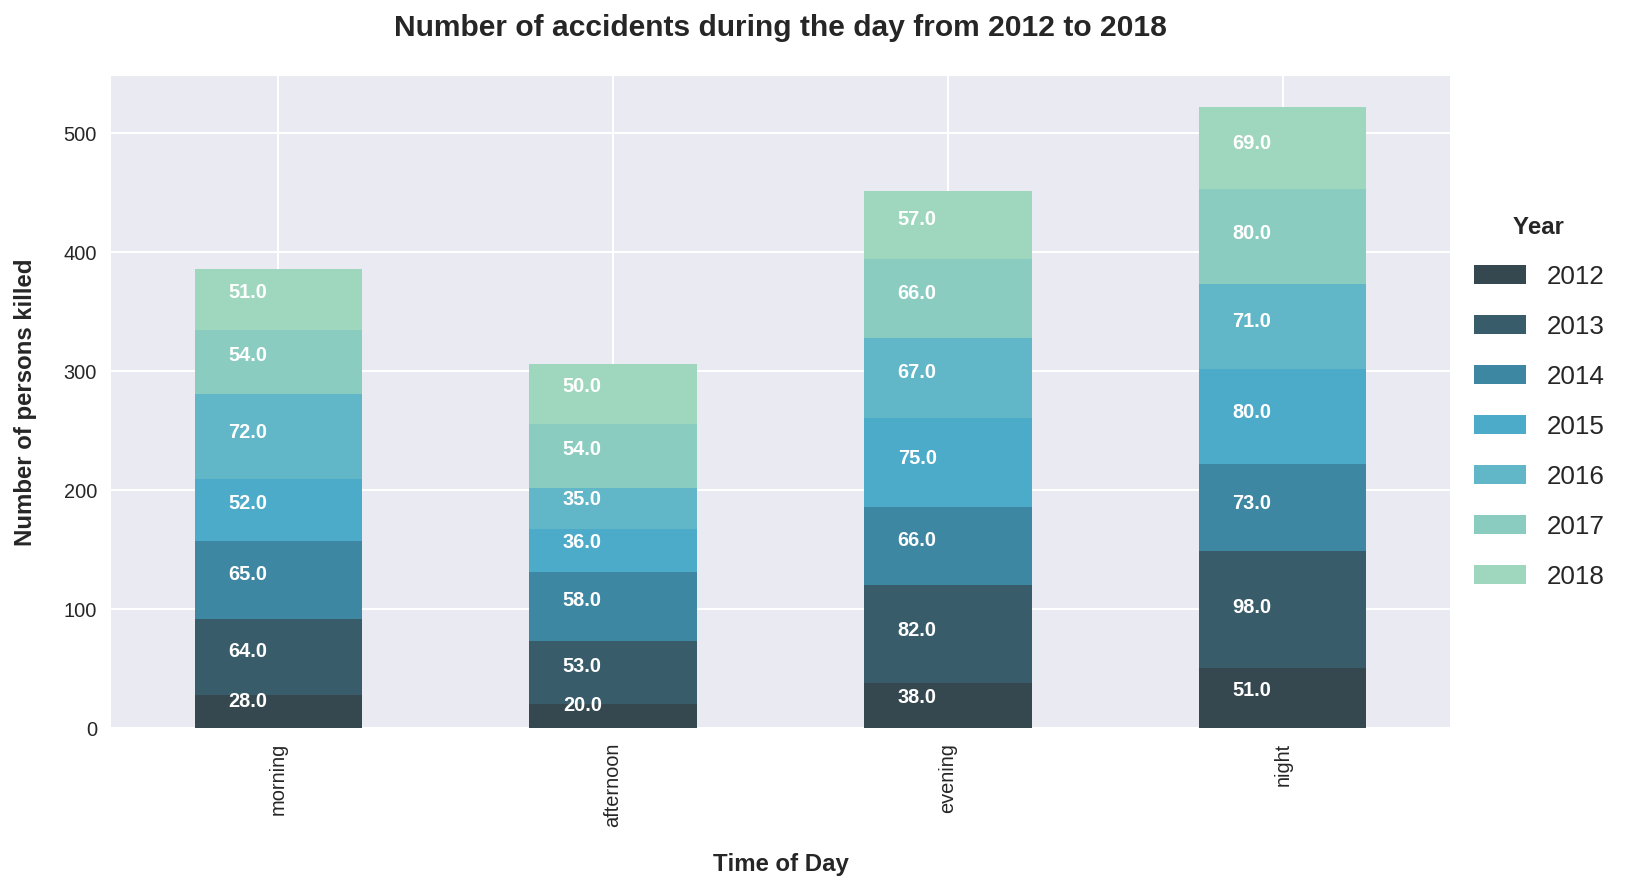

In [19]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
from matplotlib.colors import ListedColormap  #import colourmap


#Size of the figure
plt.rcParams["figure.figsize"]=12,6 #(width, height)

graph=df.groupby(['hour_category', 'year'])['NUMBER OF PERSONS KILLED'].sum().unstack()
ax= graph.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette('GnBu_d', 10)))


#Axis labels and adjustments
plt.xlabel('Time of Day', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Number of persons killed', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Number of accidents during the day from 2012 to 2018',  fontweight='bold', fontsize=15, pad=20)


#Legend
lg=ax.legend(['2012','2013','2014','2015','2016','2017','2018'],
          title="Year",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13, labelspacing=1)

title = lg.get_title()
title.set_fontsize(12)
title.set_weight('bold')


#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')

###  Number of accidents during the week from 2012 to 2018

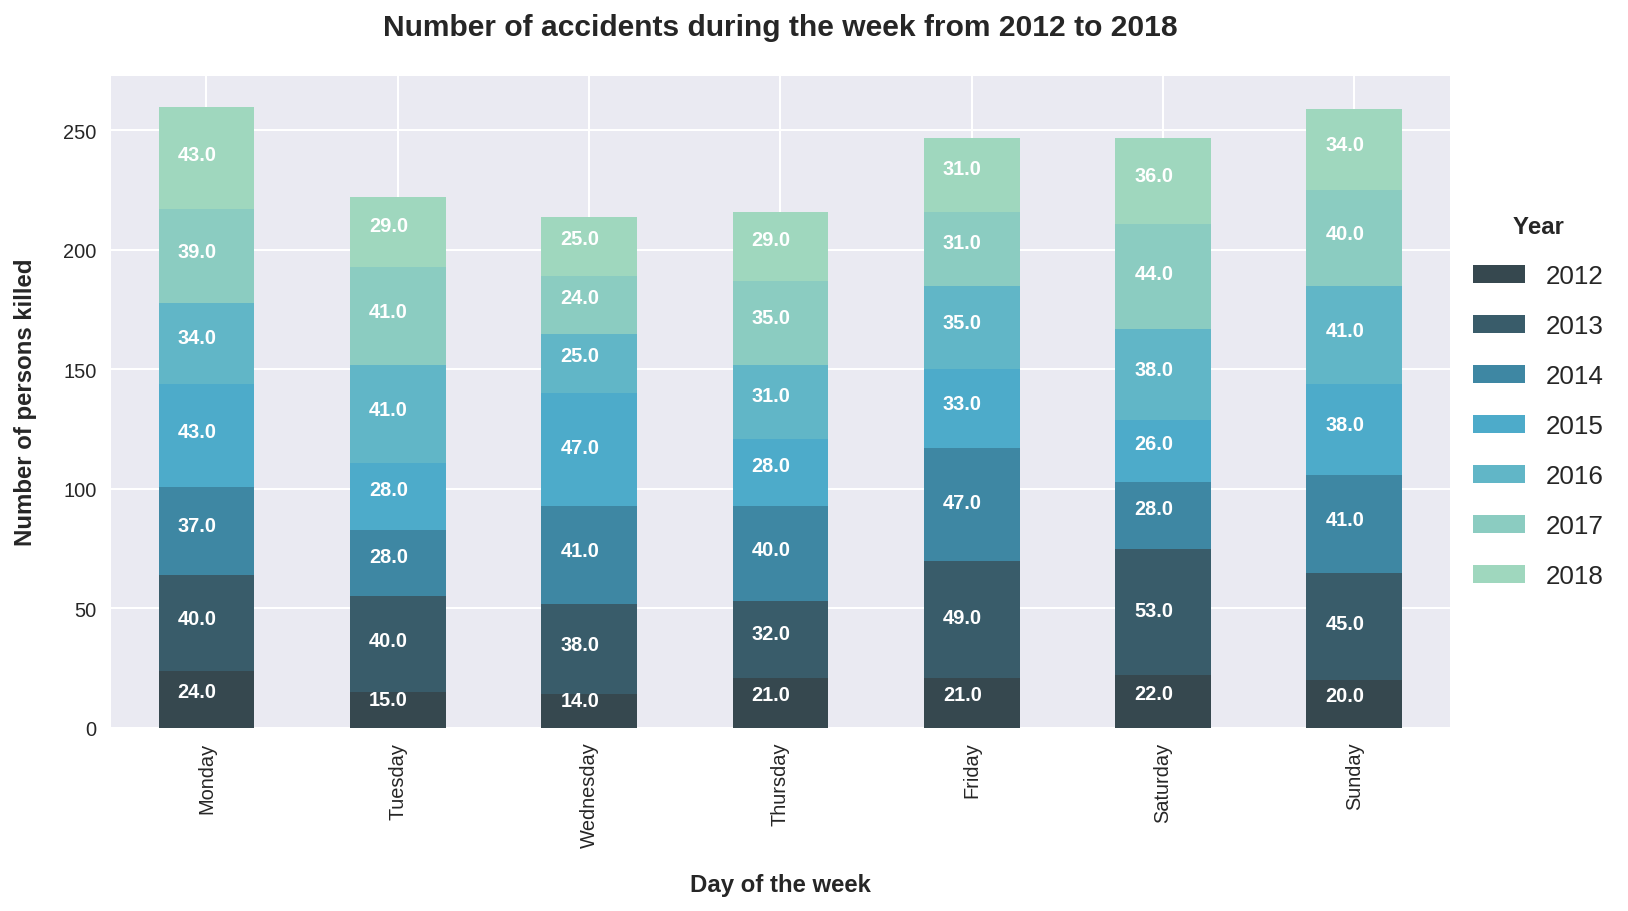

In [20]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
from matplotlib.colors import ListedColormap  #import colourmap
#Size of the figure
plt.rcParams["figure.figsize"]=12,6 #(width, height)


graph=df.groupby(['day_of_week', 'year'])['NUMBER OF PERSONS KILLED'].sum().unstack()
ax= graph.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette('GnBu_d', 10)))


#Axis labels and adjustments
plt.xlabel('Day of the week', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Number of persons killed', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Number of accidents during the week from 2012 to 2018',  fontweight='bold', fontsize=15, pad=20)


#Legend
lg=ax.legend(['2012','2013','2014','2015','2016','2017','2018'],
          title="Year",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13, labelspacing=1)

title = lg.get_title()
title.set_fontsize(12)
title.set_weight('bold')


#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')


###  Number of accidents during the year from 2012 to 2018

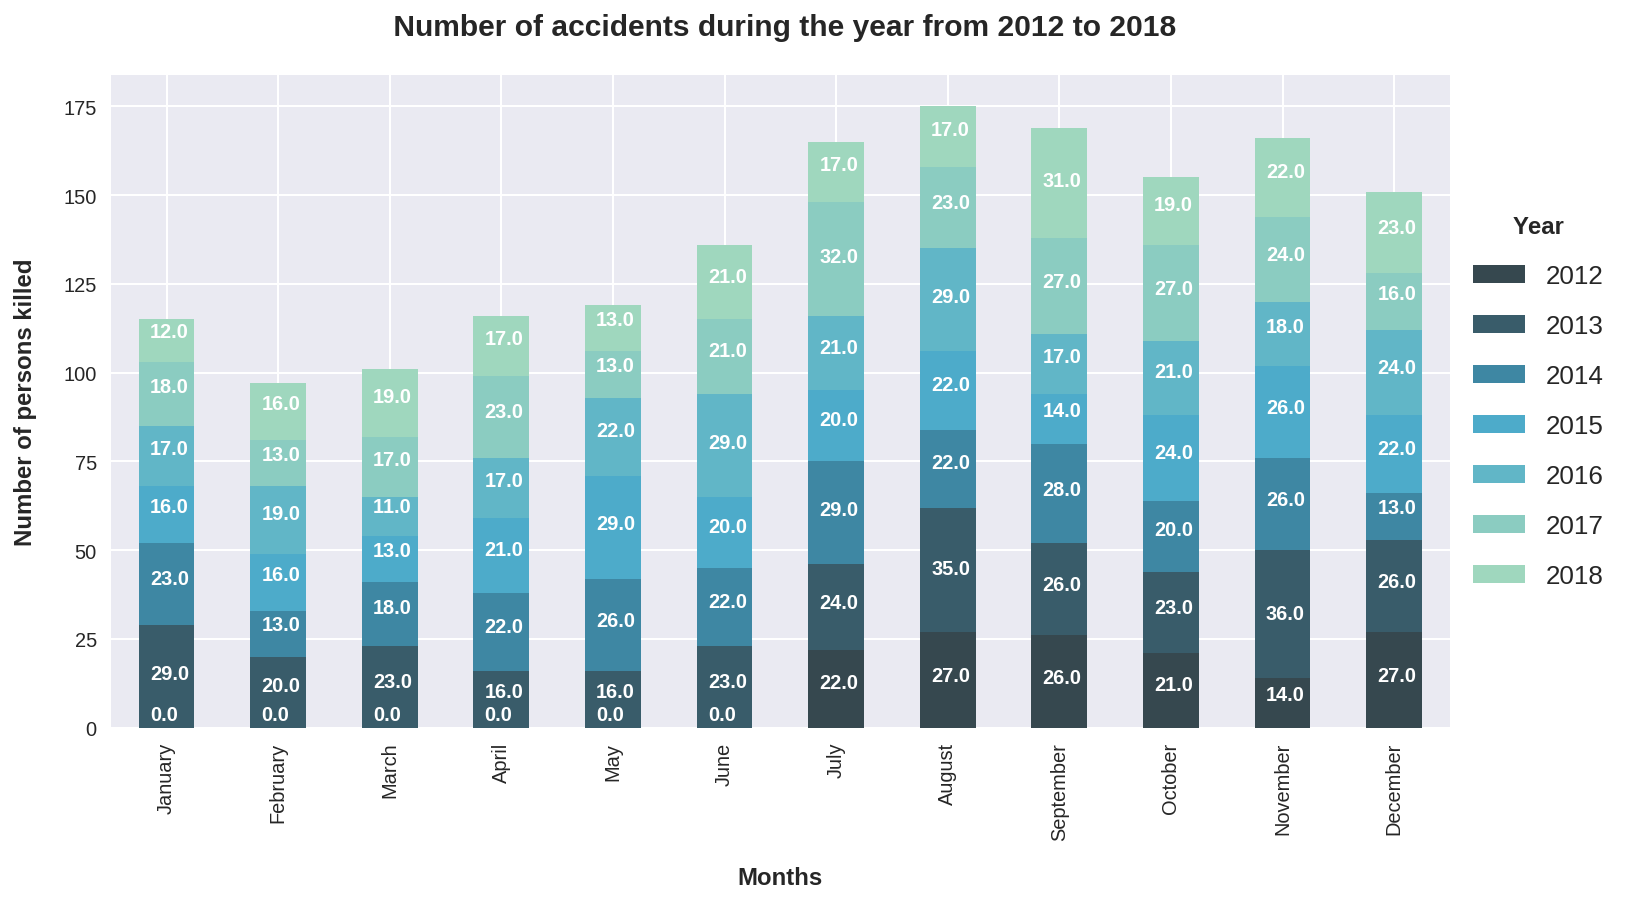

In [21]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
from matplotlib.colors import ListedColormap  #import colourmap
#Size of the figure
plt.rcParams["figure.figsize"]=12,6 #(width, height)
graph=df.groupby(['month','year'])['NUMBER OF PERSONS KILLED'].sum().unstack()
ax= graph.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette('GnBu_d', 10)))


#Axis labels and adjustments
plt.xlabel('Months', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Number of persons killed', fontweight='bold', labelpad=13, fontsize=12)
plt.title(' Number of accidents during the year from 2012 to 2018',  fontweight='bold', fontsize=15, pad=20)

#Legend
lg=ax.legend(['2012','2013','2014','2015','2016','2017','2018'],
          title="Year",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13, labelspacing=1)

title = lg.get_title()
title.set_fontsize(12)
title.set_weight('bold')

#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')

### Leading contributors to car accidents


In [22]:
# Leading causes of a car accident
count = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(11)
count[count < 300000]

Driver Inattention/Distraction    258958
Failure to Yield Right-of-Way      80965
Following Too Closely              65995
Backing Unsafely                   54527
Fatigued/Drowsy                    46709
Other Vehicular                    46550
Turning Improperly                 37800
Passing or Lane Usage Improper     31165
Passing Too Closely                28316
Unsafe Lane Changing               25831
Name: CONTRIBUTING FACTOR VEHICLE 1, dtype: int64

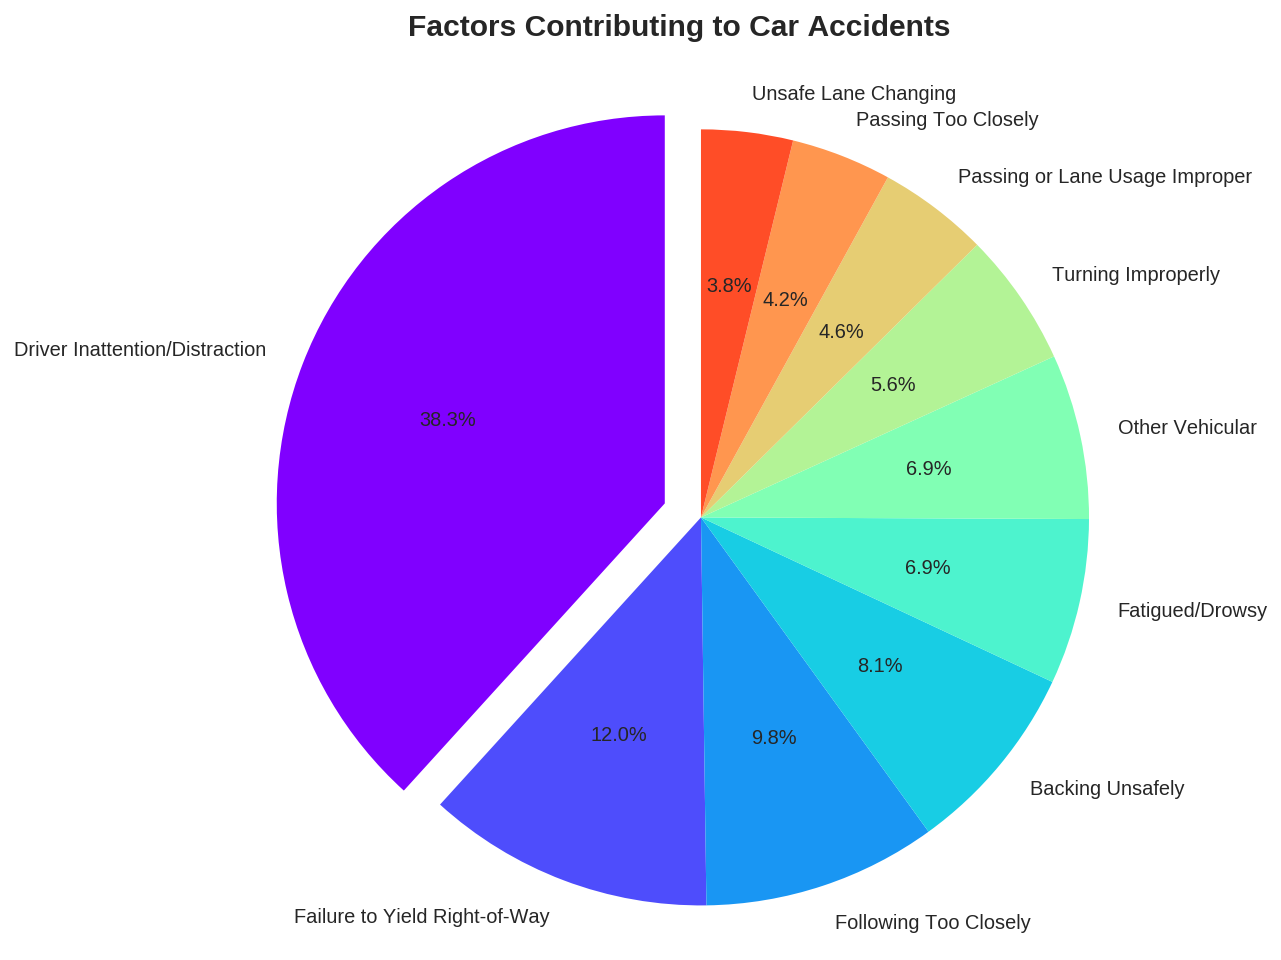

In [23]:
from matplotlib import cm
labels =[ 'Driver Inattention/Distraction', 'Failure to Yield Right-of-Way', 'Following Too Closely',
         'Backing Unsafely', 'Fatigued/Drowsy', 'Other Vehicular', 'Turning Improperly', 
         'Passing or Lane Usage Improper', 'Passing Too Closely', 'Unsafe Lane Changing']
colors = cm.rainbow(np.arange(30)/10)
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode 1st slice
fig=plt.figure(figsize=[8, 8])
slices= count[count < 300000]
# Plot
plt.pie(slices, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
plt.title('Factors Contributing to Car Accidents',  fontweight='bold', fontsize=15, pad=20)
plt.axis('equal')
plt.show()


## Streets with the highest number of accidents

In [24]:
# Leading causes of a car accident
df['ON STREET NAME'].value_counts().nlargest(10)

BROADWAY                            14617
ATLANTIC AVENUE                     13010
3 AVENUE                            10458
NORTHERN BOULEVARD                  10264
BELT PARKWAY                         8564
FLATBUSH AVENUE                      8458
QUEENS BOULEVARD                     8169
LINDEN BOULEVARD                     7911
2 AVENUE                             7598
BROOKLYN QUEENS EXPRESSWAY           6659
Name: ON STREET NAME, dtype: int64

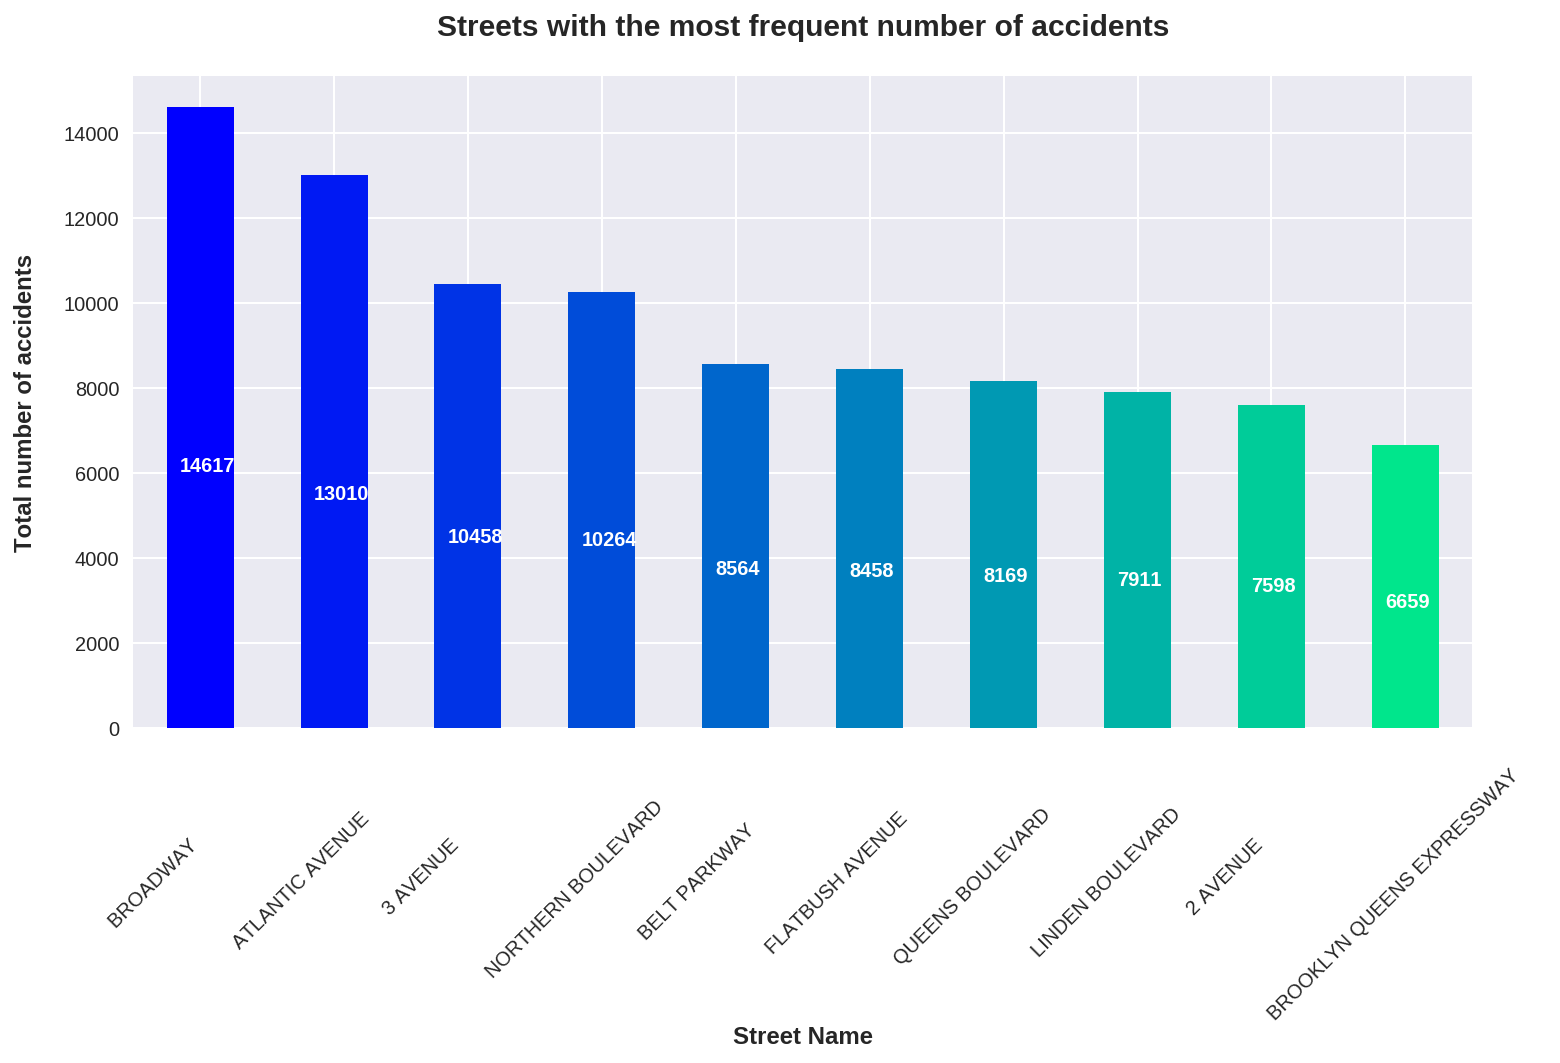

In [25]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
from matplotlib.colors import ListedColormap  #import colourmap


#Size of the figure
plt.rcParams["figure.figsize"]=12,6 #(width, height)


graph=df['ON STREET NAME'].value_counts().nlargest(10)
ax= graph.plot.bar(stacked=True, color=cm.winter(np.arange(30)/10))


#Axis labels and adjustments
plt.xlabel('Street Name', fontweight='bold', labelpad=1, fontsize=12)
plt.ylabel('Total number of accidents', fontweight='bold', labelpad=13, fontsize=12)
plt.xticks(rotation = 45,size = 10)
plt.title('Streets with the most frequent number of accidents',  fontweight='bold', fontsize=15, pad=20)


#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')

In [26]:
df['BOROUGH'].value_counts()

BROOKLYN         315700
QUEENS           269606
MANHATTAN        249623
BRONX            139899
STATEN ISLAND     46211
Name: BOROUGH, dtype: int64

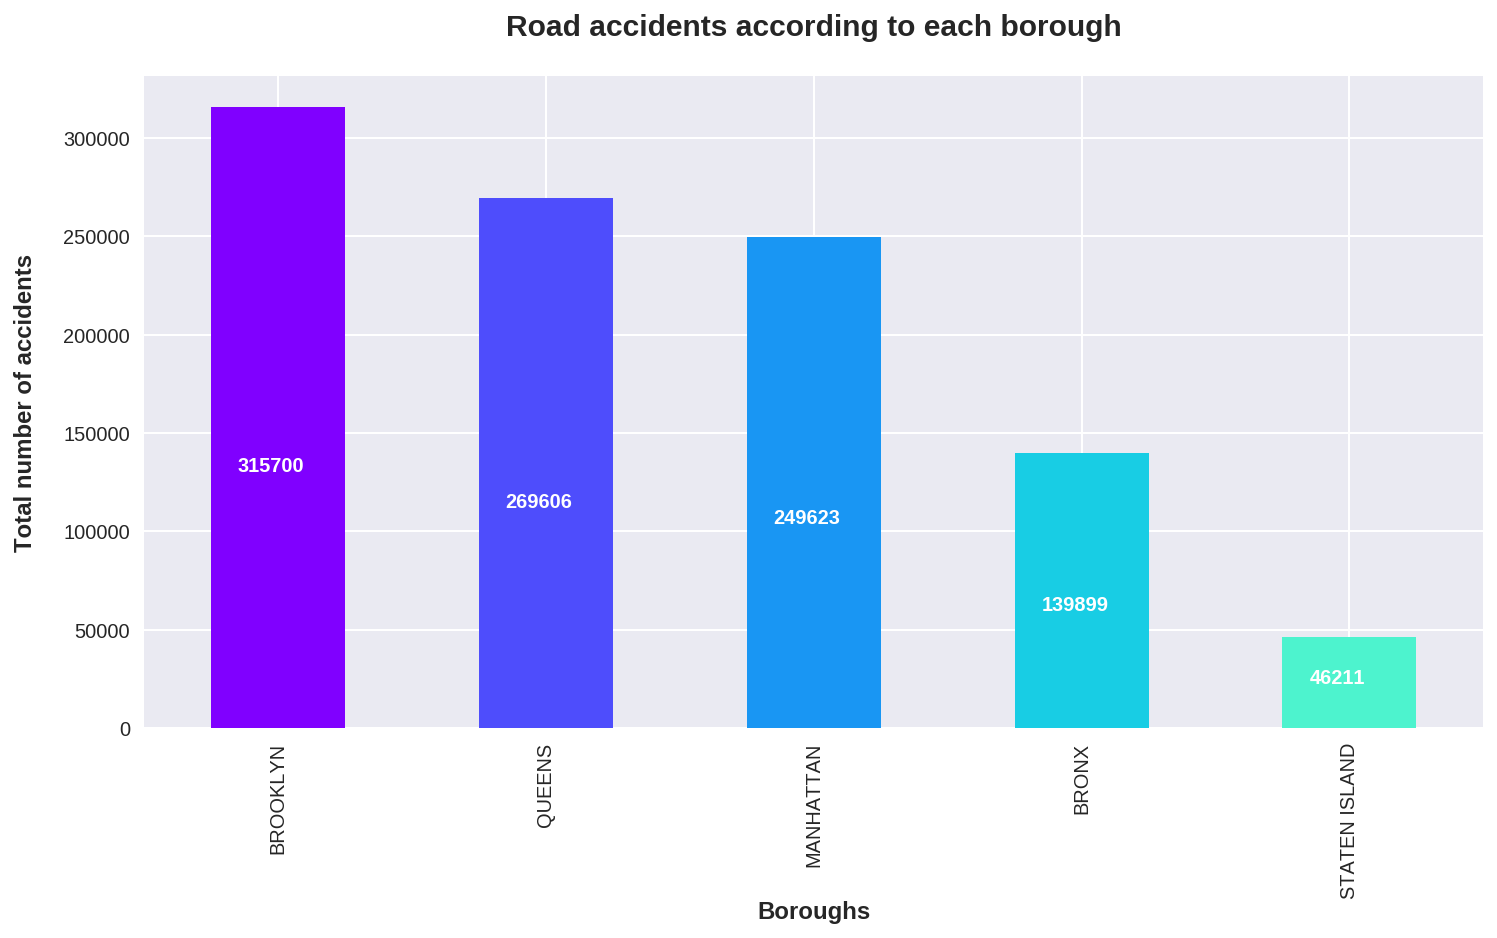

In [27]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
from matplotlib.colors import ListedColormap  #import colourmap


#Size of the figure
plt.rcParams["figure.figsize"]=12,6 #(width, height)


graph=df['BOROUGH'].value_counts()
ax= graph.plot.bar(stacked=True, color=cm.rainbow(np.arange(30)/10))


#Axis labels and adjustments
plt.xlabel('Boroughs', fontweight='bold', labelpad=1, fontsize=12)
plt.ylabel('Total number of accidents', fontweight='bold', labelpad=13, fontsize=12)
plt.xticks(rotation = 90,size = 10)
plt.title('Road accidents according to each borough',  fontweight='bold', fontsize=15, pad=20)


#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import gmplot
import webbrowser,os
import folium

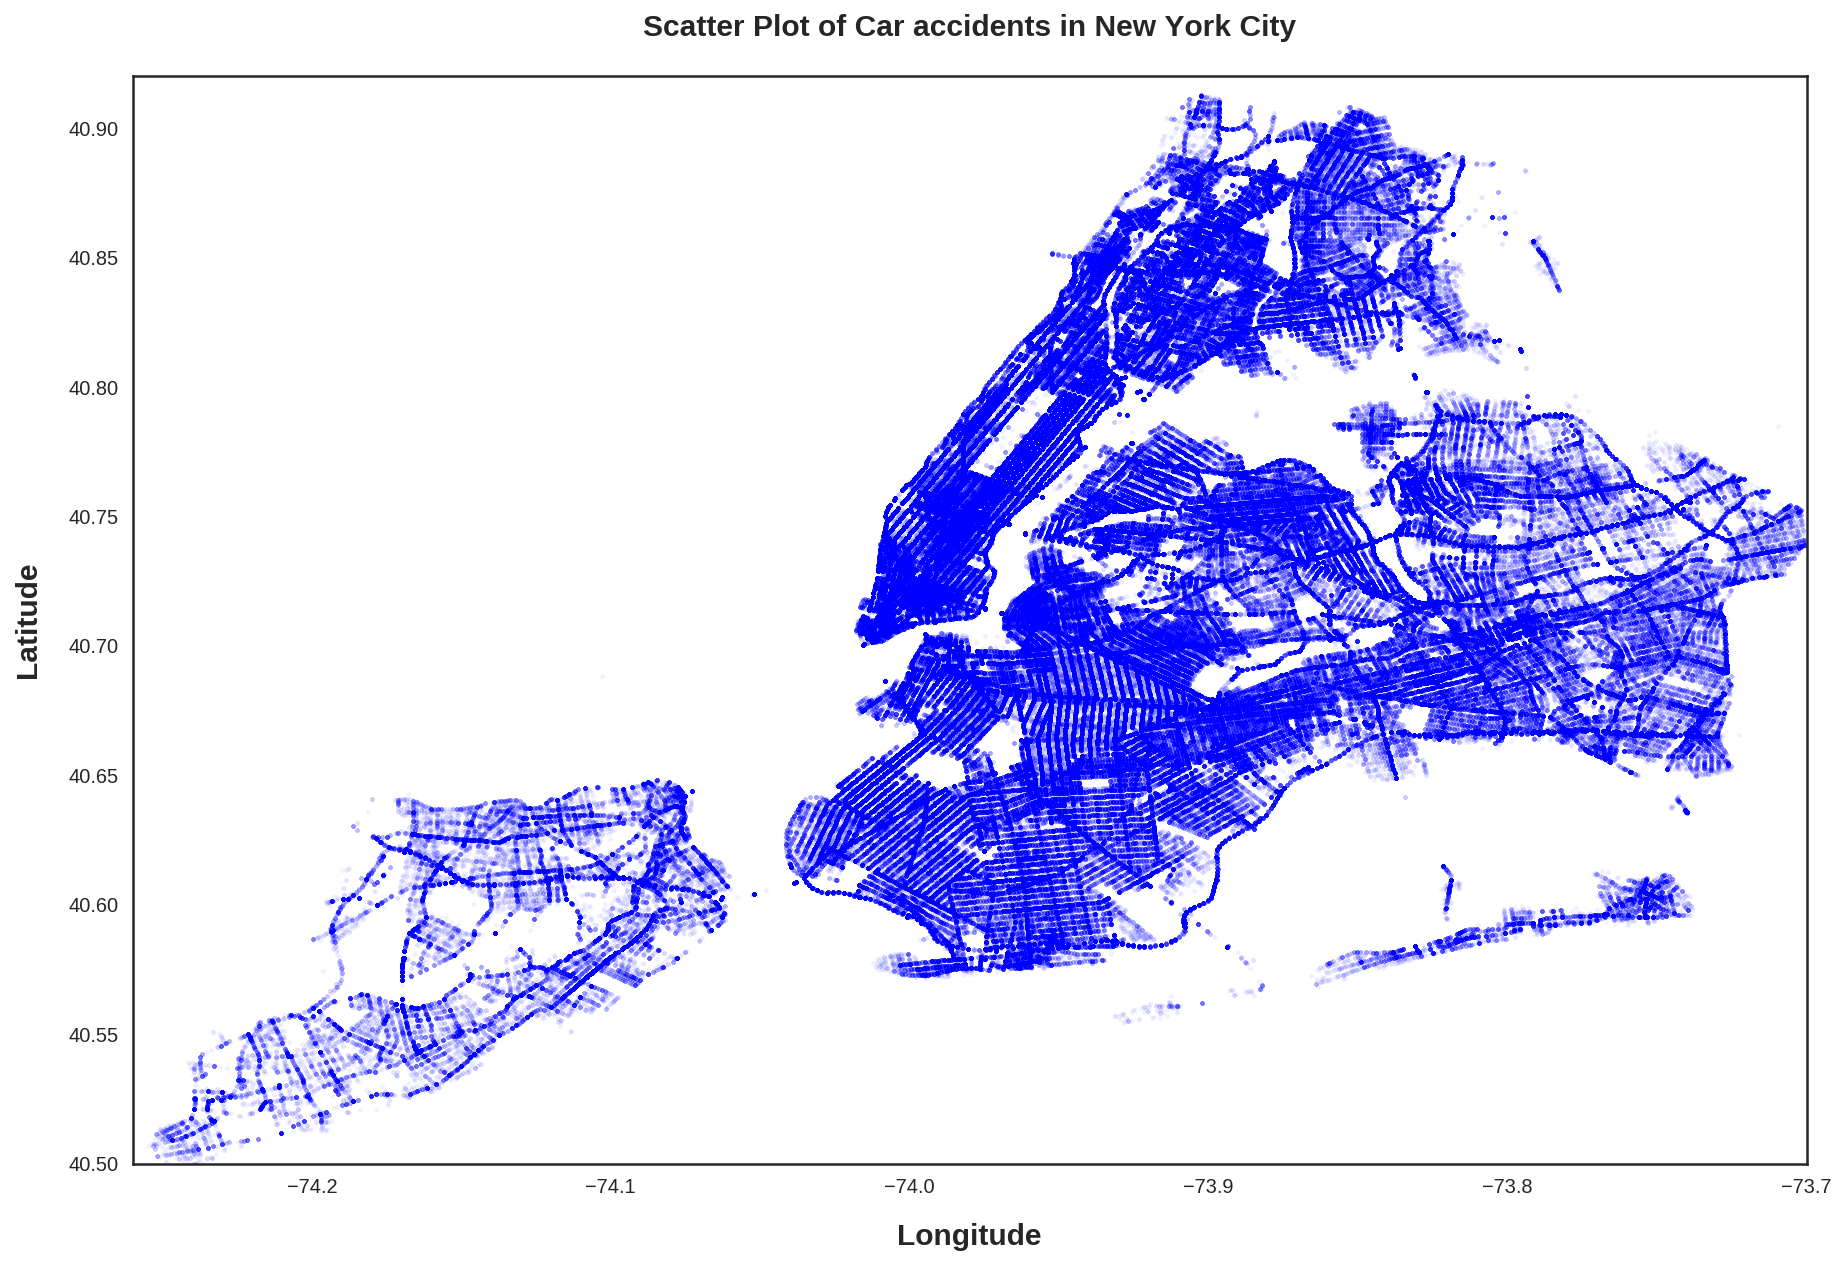

In [29]:
sns.set_style("white")
plt.figure(figsize=(15,10))

plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha=0.05, s=4, color='blue')

plt.title('Scatter Plot of Car accidents in New York City', size=15, fontweight='bold', pad=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',fontweight='bold', labelpad=13, fontsize=15)
plt.ylabel('Latitude',fontweight='bold', labelpad=13, fontsize=15)
plt.show()

In [30]:
lon1= df.loc[df['BOROUGH']=='MANHATTAN', 'LONGITUDE']
lat1= df.loc[df['BOROUGH']=='MANHATTAN', 'LATITUDE']
lon2= df.loc[df['BOROUGH']=='BROOKLYN', 'LONGITUDE']
lat2= df.loc[df['BOROUGH']=='BROOKLYN', 'LATITUDE']
lon3= df.loc[df['BOROUGH']=='BRONX', 'LONGITUDE']
lat3= df.loc[df['BOROUGH']=='BRONX', 'LATITUDE']
lon4= df.loc[df['BOROUGH']=='QUEENS', 'LONGITUDE']
lat4= df.loc[df['BOROUGH']=='QUEENS', 'LATITUDE']
lon5= df.loc[df['BOROUGH']=='STATEN ISLAND', 'LONGITUDE']
lat5= df.loc[df['BOROUGH']=='STATEN ISLAND', 'LATITUDE']

In [42]:
boroughs =['MANHATTAN', 'BROOKLYN', 'BRONX', 'QUEENS', 'STATEN ISLAND']

d={}
for x in range(1,6):
    for b in boroughs:
        d["lon{0}".format(x)]= df.loc[df['BOROUGH']==b, 'LONGITUDE']
        d["lat{0}".format(x)]= df.loc[df['BOROUGH']==b, 'LATITUDE']

In [52]:
d['lon3'].nunique()

10121

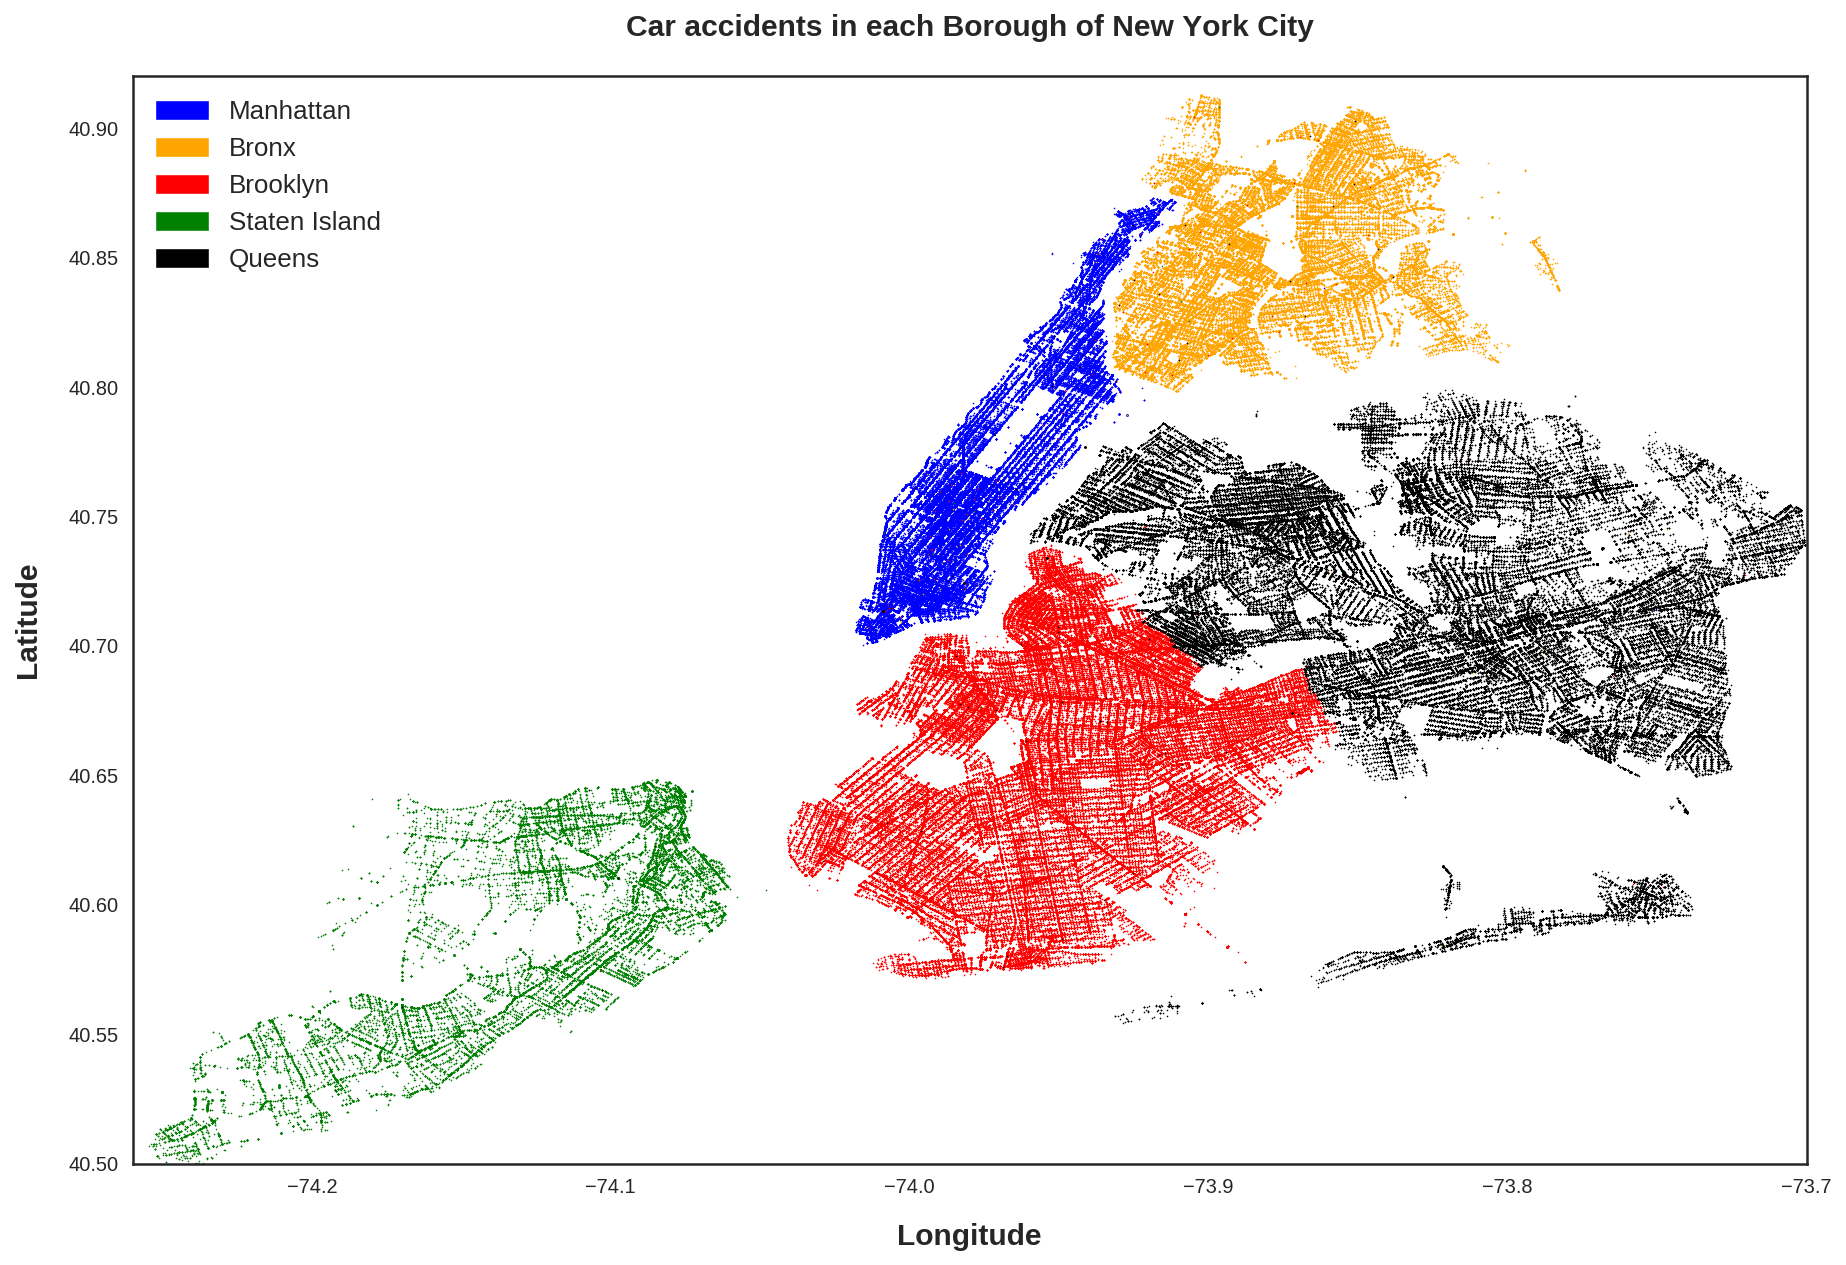

In [31]:
# 1 - Manhattan, 2-Brooklyn, 3-Bronx, 4-Queens, 5-Staten Island
sns.set_style("white")
plt.figure(figsize=(15,10))

plt.scatter(lon1, lat1, s=1, color='blue', marker ='.')
plt.scatter(lon3, lat3, s=1, color='orange', marker ='.')
plt.scatter(lon2, lat2, color='red', s=1, marker ='.')
plt.scatter(lon5, lat5, s=1, color='green', marker ='.')
plt.scatter(lon4, lat4, s=1, color='black', marker ='.')

blue_patch = mpatches.Patch(label='Manhattan', color='blue')
yellow_patch = mpatches.Patch(color='orange', label='Bronx')
red_patch = mpatches.Patch(color='red', label='Brooklyn')
green_patch = mpatches.Patch(color='green', label='Staten Island')
black_patch = mpatches.Patch(color='black', label='Queens')
plt.legend([blue_patch, yellow_patch, red_patch, green_patch, black_patch],
           ('Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'), 
           loc='upper left', prop={'size':13})

plt.title('Car accidents in each Borough of New York City', size=15, fontweight='bold', pad=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude', fontweight='bold', labelpad=13, fontsize=15)
plt.ylabel('Latitude', fontweight='bold', labelpad=13, fontsize=15)
plt.show()

### Type of Vehicles involved in road accident

In [32]:
# Leading causes of a car accident
cars= df['VEHICLE TYPE CODE 1'].value_counts().nlargest(9)
cars

PASSENGER VEHICLE                      715236
SPORT UTILITY / STATION WAGON          313499
Sedan                                   88206
Station Wagon/Sport Utility Vehicle     69270
TAXI                                    50670
VAN                                     26540
OTHER                                   23982
PICK-UP TRUCK                           23069
UNKNOWN                                 19929
Name: VEHICLE TYPE CODE 1, dtype: int64

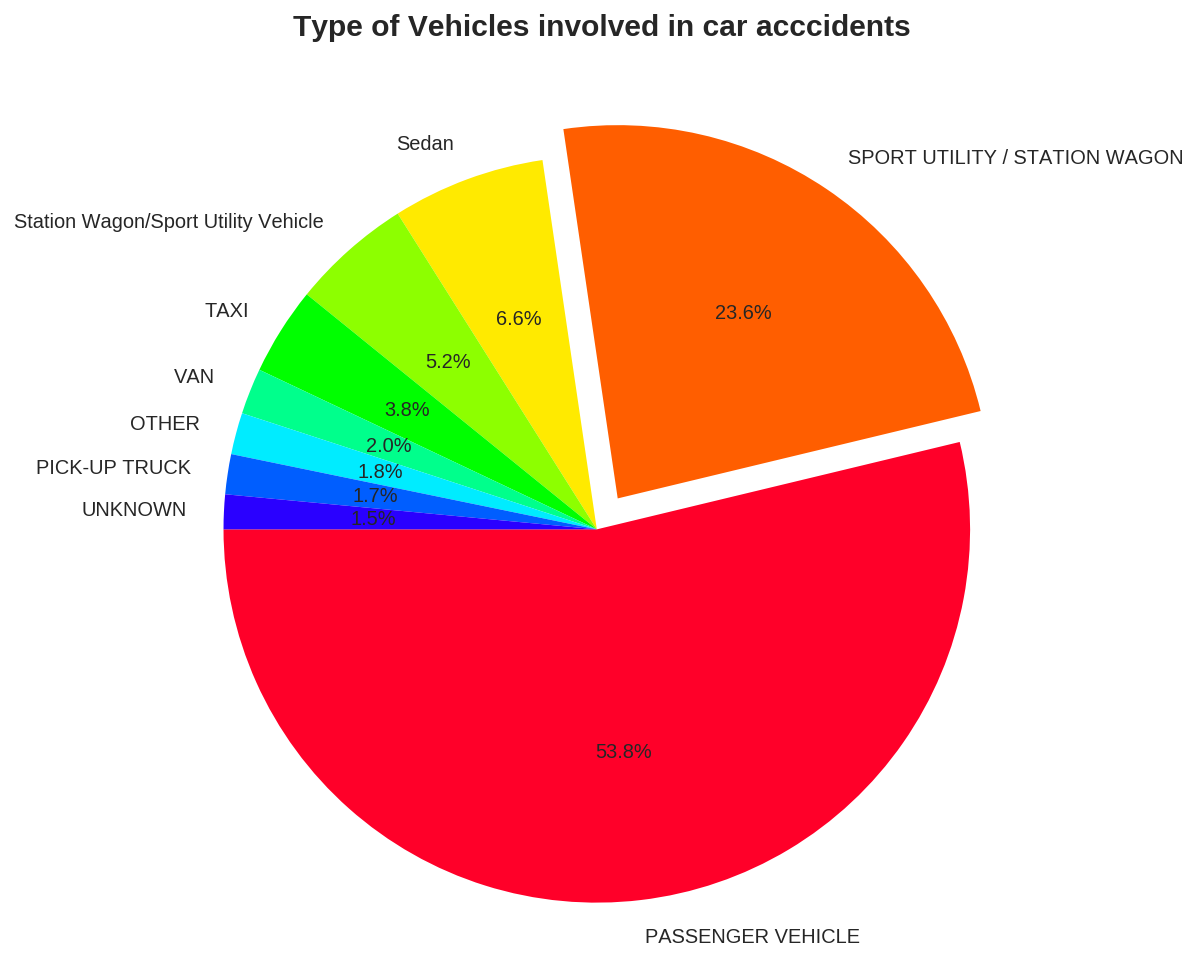

In [33]:
from matplotlib import cm
labels =[ 'PASSENGER VEHICLE', 'SPORT UTILITY / STATION WAGON', 'Sedan', 'Station Wagon/Sport Utility Vehicle', 
         'TAXI', 'VAN', 'OTHER', 'PICK-UP TRUCK', 'UNKNOWN']
colors = cm.gist_rainbow(np.arange(30)/10)
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0)  # explode 1st slice
fig=plt.figure(figsize=[8, 8])
slices= cars
# Plot
plt.pie(slices, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=180)
plt.title('Type of Vehicles involved in car acccidents',  fontweight='bold', fontsize=15, pad=20)
plt.axis('equal')
plt.show()
